# Examine changes in viable habitat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from itertools import product
import json
import yaml
import intake
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import funnel
import data_collections as dc
import operators as ops
import util


import traits_db
import metabolic as mi

Modify `groupby_attrs` to remove `member_id` so that that ends up as a dimension in the datasets.

In [3]:
df = mi.open_traits_df()
df

,Species,Phylum,alphaD_log10,Emet,Eo,Ao,Ac,Phi_crit
0,Acanthephyra acutifrons,Crustacea,0.479565,0.040200,-0.027836,0.264715,0.131959,2.006040
1,Acanthephyra curtirostris,Crustacea,0.377714,0.043938,0.038027,0.252578,0.141861,1.780456
2,Acanthephyra purpurea,Crustacea,1.035748,0.840722,0.131972,0.230068,0.073638,3.124330
3,Acanthephyra smithi,Crustacea,1.082577,0.313173,-0.030067,0.286307,0.174423,1.641453
4,Acipenser brevirostrum,Chordata,NaN,NaN,0.362569,0.218524,0.048415,4.513525
...,...,...,...,...,...,...,...,...
56,Styela plicata,Tunicata,0.433791,0.346635,-0.190998,0.061336,0.043505,1.409863
57,Systellaspis debilis,Crustacea,0.779626,0.418652,0.226970,0.219289,0.096003,2.284196
58,Tarletonbeania crenularis,Chordata,NaN,NaN,0.213307,0.203696,0.051780,3.933876
59,Tautogolabrus adspersus,Chordata,0.801974,0.327012,0.244520,0.170886,0.051204,3.337395


<xarray.DataArray 'Ac' (Ac: 8)>
array([0.0258, 0.0399, 0.0619, 0.0959, 0.1486, 0.2303, 0.3568, 0.5528])
Dimensions without coordinates: Ac
Attributes:
    long_name:  Hypoxic tolerance (normalized by critical MI)
    units:      1/kPa

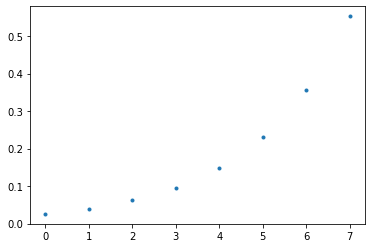

In [4]:
log10_values = np.log10(df.Ac.values)
Ac_coord_data = np.round(np.logspace(log10_values.min(), log10_values.max(), 8, base=10), 4)
Ac_coord = xr.DataArray(Ac_coord_data, dims=('Ac'), name='Ac')
Ac_coord.attrs = df.Ac.attrs
plt.plot(Ac_coord, '.');
Ac_coord

<xarray.DataArray 'Eo' (Eo: 7)>
array([-0.2, -0. ,  0.2,  0.4,  0.6,  0.8,  1. ])
Dimensions without coordinates: Eo
Attributes:
    long_name:  Temperature sensitivity of MI
    units:      eV

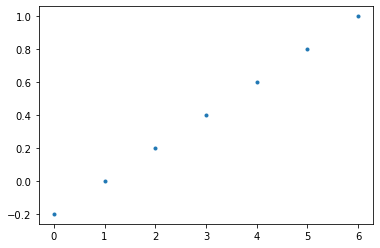

In [5]:
Eo_coord = xr.DataArray(np.round(np.linspace(-0.2, 1., 7), 4), dims=('Eo'), name=('Eo'))
Eo_coord.attrs = df.Eo.attrs
plt.plot(Eo_coord, '.');
Eo_coord

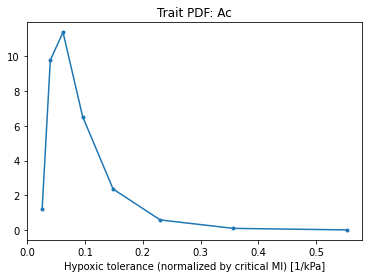

In [6]:
obj_Ac_pdf = mi.trait_pdf(df, 'Ac')
plt.plot(Ac_coord, obj_Ac_pdf.fitted(Ac_coord), '.-');
plt.title('Trait PDF: Ac');
plt.xlabel(util.attrs_label(df.Ac.attrs));

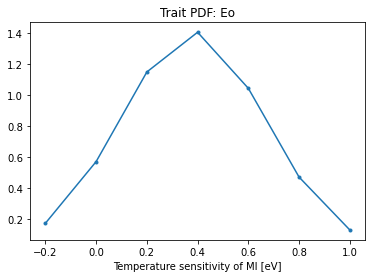

In [7]:
obj_Eo_pdf = mi.trait_pdf(df, 'Eo')
plt.plot(Eo_coord, obj_Eo_pdf.fitted(Eo_coord), '.-');
plt.title('Trait PDF: Eo');
plt.xlabel(util.attrs_label(df.Eo.attrs));

In [8]:
trait_spc_wgt = (
    xr.DataArray(obj_Ac_pdf.fitted(Ac_coord), dims=('Ac'), coords={'Ac': Ac_coord}) *
    xr.DataArray(obj_Eo_pdf.fitted(Eo_coord), dims=('Eo'), coords={'Eo': Eo_coord})
)

trait_spc_wgt /= trait_spc_wgt.sum()                 
trait_spc_wgt.attrs['long_name'] = 'Trait density'
assert trait_spc_wgt.sum() == 1.
trait_spc_wgt

<xarray.DataArray (Ac: 8, Eo: 7)>
array([[1.34680503e-03, 4.47545908e-03, 9.02342586e-03, 1.10384049e-02,
        8.19298555e-03, 3.68959807e-03, 1.00813091e-03],
       [1.06140909e-02, 3.52708287e-02, 7.11130864e-02, 8.69930173e-02,
        6.45684353e-02, 2.90775046e-02, 7.94502019e-03],
       [1.23591079e-02, 4.10695540e-02, 8.28044832e-02, 1.01295165e-01,
        7.51838542e-02, 3.38580121e-02, 9.25122680e-03],
       [7.08526930e-03, 2.35444865e-02, 4.74704214e-02, 5.80708193e-02,
        4.31016426e-02, 1.94102305e-02, 5.30357316e-03],
       [2.56701395e-03, 8.53023685e-03, 1.71986736e-02, 2.10392290e-02,
        1.56158521e-02, 7.03238370e-03, 1.92150019e-03],
       [6.36403263e-04, 2.11478032e-03, 4.26382256e-03, 5.21595685e-03,
        3.87141615e-03, 1.74343888e-03, 4.76370216e-04],
       [1.11418788e-04, 3.70246781e-04, 7.46491996e-04, 9.13187634e-04,
        6.77791144e-04, 3.05233896e-04, 8.34008799e-05],
       [1.39113912e-05, 4.62278214e-05, 9.32045879e-05, 1.14017669e-04,
        8.46268206e-05, 3.81105218e-05, 1.04131654e-05]])
Coordinates:
  * Ac       (Ac) float64 0.0258 0.0399 0.0619 0.0959 ... 0.2303 0.3568 0.5528
  * Eo       (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
Attributes:
    long_name:  Trait density

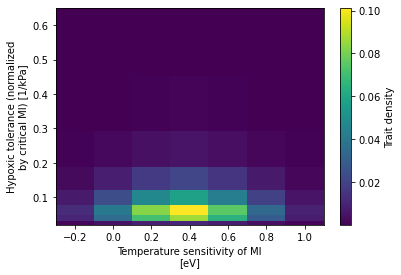

In [9]:
trait_spc_wgt.plot();

In [10]:
dEodT_bar = -0.0226
dEodT_bar

-0.0226

In [11]:
catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids[1:],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,33
variable,7
name,1
path,1609
Eo,6
dEodT,1
Ac,6


In [12]:
catalog.search(experiment='20C', variable=['pO2', 'TEMP'], member_id=10).df

,experiment,component,stream,member_id,variable,name,path,Eo,dEodT,Ac
0,20C,ocn,pop.h,10,TEMP,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...,NaN,NaN,NaN
1,20C,ocn,pop.h,10,pO2,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...,NaN,NaN,NaN


In [13]:
cache_dir = '/glade/scratch/mclong/ocean-metabolism/funnel-cache'

def _gen_cache_file_name(experiment, component, stream, member_id, variable):
    return f'{cache_dir}/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.zarr'


def _make_cache(experiment, component, stream, member_id, variable):
    """
    Manually generate funnel catalog entry
    
    I.e.:
    asset: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.TEMP.drift-corrected.zarr
    esm_collection: data/catalogs/glade-cesm1-le.json
    key: 20C.ocn.pop.h.101
    name: drift-corrected
    operator_kwargs:
    - {}
    - {}
    - {}
    operators:
    - compute_time
    - sel_time_slice
    - compute_drift_correction
    preprocess: _preprocess_pop_h_upper_1km
    variable: TEMP
    """
    
    cache_id_dict = dict(
        asset=_gen_cache_file_name(experiment, component, stream, member_id, variable, additional_coord_values),
        esm_collection='data/catalogs/glade-cesm1-le.json',        
        key=f'{experiment}.{component}.{stream}.{member_id}',
        name='drift-corrected',
        operator_kwargs=[{}, {}, {}],
        operators=['compute_time', 'sel_time_slice', 'compute_drift_correction'],
        preprocess='_preprocess_pop_h_upper_1km',
        variable=variable,
    )
    cache_id_file = f'data/funnel-catalog/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.yml'
    with open(cache_id_file, 'w') as fid:
        yaml.dump(cache_id_dict, fid)    
        

In [14]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='100GB')
    cluster.scale(34)
client    

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.29:45019,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [15]:
# refresh catalog
catalog = funnel.to_intake_esm(agg_member_id=False).search(**sub_spec)
experiment_list = sorted(catalog.unique('experiment')['experiment']['values'])
member_id_list = sorted(catalog.unique('member_id')['member_id']['values'])[1:4]

In [ ]:
clobber = False

stream = 'pop.h'
component = 'ocn'
    
variable = 'vol_viable_trait_pdf'

for experiment, member_id in product(experiment_list, member_id_list):
    
    with util.timer(f'{experiment}.{member_id}'):
    
        cat = catalog.search(
            experiment=experiment, 
            member_id=member_id, 
            stream=stream, 
            component=component,
            variable=['TEMP', 'pO2'],
        )

        # ensure variables
        missing_vars = {'TEMP', 'pO2'} - set(cat.df.variable.to_list())
        if missing_vars:
            print(f'missing vars for {experiment}.{member_id:03d}: {missing_vars}')
            continue

        dset = cat.to_dataset_dict()
        assert len(dset.keys()) == 1    
        _, ds = dset.popitem()

        # check for existing cache file
        asset = _gen_cache_file_name(experiment, component, stream, member_id, variable)

        if clobber and os.path.exists(asset):
            print(f'removing: {asset}')
            shutil.rmtree(asset)

        if os.path.exists(asset):
            print(f'exists: {asset}')
            continue    

        # compute 
        print(f'computing: {asset}')

        ones_time = xr.full_like(ds.time, fill_value=1.)
        vol = ones_time * (ds.dz * ds.TAREA) * 1e-6 
        vol.attrs['units'] = 'm^3'

        # compute trait-density weighted sum
        vol_viable = xr.full_like(vol.isel(z_t=0, drop=True), fill_value=0.)         
        for Eo, Ac in product(Eo_coord.values, Ac_coord.values):
            print(f'Eo={Eo}, Ac={Ac}')
            # compute the metabolic index
            Phi = mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=dEodT_bar)

            # compute the vertical integral of habitat volume where Φ > 1
            vol_masked = vol.where(Phi > 1).sum('z_t')

            # multiply by trait space weighting
            vol_masked *= trait_spc_wgt.sel(Eo=Eo, Ac=Ac)        

            # update sum
            vol_viable += vol_masked
            vol_viable = vol_viable.persist()

        print(f'writing: {asset}')
        dso = ds[['TAREA', 'KMT', 'TLONG', 'TLAT', 'KMT', 'z_t', 'dz']]
        dso[variable] = vol_viable    
        dso.to_zarr(asset, mode='w', consolidated=True)    
        _make_cache(experiment, component, stream, member_id, variable)


    #    break


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.vol_viable_trait_pdf.drift-corrected.zarr
Eo=-0.2, Ac=0.0258
Eo=-0.2, Ac=0.0399
Eo=-0.2, Ac=0.0619
Eo=-0.2, Ac=0.0959
Eo=-0.2, Ac=0.1486
Eo=-0.2, Ac=0.2303
Eo=-0.2, Ac=0.3568
Eo=-0.2, Ac=0.5528
Eo=-0.0, Ac=0.0258
Eo=-0.0, Ac=0.0399
Eo=-0.0, Ac=0.0619
Eo=-0.0, Ac=0.0959
Eo=-0.0, Ac=0.1486
Eo=-0.0, Ac=0.2303
Eo=-0.0, Ac=0.3568
Eo=-0.0, Ac=0.5528
Eo=0.2, Ac=0.0258
Eo=0.2, Ac=0.0399
Eo=0.2, Ac=0.0619
Eo=0.2, Ac=0.0959
Eo=0.2, Ac=0.1486
Eo=0.2, Ac=0.2303
Eo=0.2, Ac=0.3568
Eo=0.2, Ac=0.5528
Eo=0.4, Ac=0.0258
Eo=0.4, Ac=0.0399
Eo=0.4, Ac=0.0619
Eo=0.4, Ac=0.0959
Eo=0.4, Ac=0.1486
Eo=0.4, Ac=0.2303
Eo=0.4, Ac=0.3568
Eo=0.4, Ac=0.5528
Eo=0.6, Ac=0.0258
Eo=0.6, Ac=0.0399
Eo=0.6, Ac=0.0619
Eo=0.6, Ac=0.0959
Eo=0.6, Ac=0.1486
Eo=0.6, Ac=0.2303
Eo=0.6, Ac=0.3568
Eo=0.6, Ac=0.5528
Eo=0.8, Ac=0.0258
Eo=0.8, Ac=0.0399
Eo=0.8, Ac=0.0619
Eo=0.8, Ac=0.0959
Eo=0.8, Ac=0.1486
Eo=0.8, Ac=0.2303
Eo=0.8, Ac=0.3568
